In [62]:
import os
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
pwd

'/home/tim/work/su-thesis-project/projects/video_analysis/python/notebooks'

In [64]:
notebooks = os.path.abspath('')
python = os.path.dirname(notebooks)
if not python in sys.path: sys.path.append(python)

In [65]:
from helpers import get_emotion_abrs_from_ids

# Paths

In [3]:
input_path = 'files/'
output_path = 'files/'
# Global configuration path
glob_conf_path = '../global_config.py'

# Load global variables

In [4]:
exec(open(glob_conf_path).read())

# Load and shuffle data

In [5]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(input_path + 'video_data_intensity_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,filename,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,...,AU45_r_mean,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,video_id,emotion_1_id,group
265,A200_reg_p_3,0.463187,0.749064,0.0,0.000000,0.203252,0.203252,0.188679,0.702141,0.733587,...,0.224003,0.199766,0.0,0.000000,0.171355,0.171355,0.650,A200,0,0
74,A102_awe_p_3,0.175606,0.933978,0.0,0.333333,0.056911,0.056911,0.056604,0.382604,0.703252,...,0.310979,0.467789,0.0,0.166667,0.084399,0.084399,0.100,A102,18,1
148,A18_awe_v_1,0.188274,0.492815,0.0,0.000000,0.198374,0.198374,0.075472,0.190862,0.426560,...,0.207909,0.572976,0.0,0.333333,0.020460,0.020460,0.025,A18,18,1
3,A101_awe_p_4,0.061996,0.400991,0.0,0.000000,0.060976,0.060976,0.358491,0.065202,0.477737,...,0.046476,0.181229,0.0,0.000000,0.031714,0.031714,0.550,A101,18,0
233,A200_dou_p_2,0.182025,0.409290,0.0,0.000000,0.178049,0.178049,0.245283,0.200819,0.541570,...,0.226453,0.214635,0.0,0.000000,0.173913,0.173913,0.175,A200,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,A101_env_p_1,0.030968,0.449200,0.0,0.166667,0.029268,0.029268,0.132075,0.096300,0.376929,...,0.308084,0.515232,0.0,0.166667,0.054220,0.054220,0.025,A101,4,0
240,A200_env_p_2,0.102112,0.580680,0.0,0.333333,0.069106,0.069106,0.150943,0.038659,0.353450,...,0.295423,0.313167,0.0,0.000000,0.165217,0.165217,0.100,A200,4,0
31,A101_env_v_4,0.168026,0.816701,0.0,0.166667,0.046341,0.046341,0.094340,0.233069,0.599587,...,0.283891,0.740826,0.0,0.166667,0.021483,0.021483,0.125,A101,4,0
184,A18_gui_p_1,0.146868,0.699797,0.0,0.333333,0.089431,0.089431,0.037736,0.118299,0.550872,...,0.239968,0.380419,0.0,0.333333,0.084399,0.084399,0.075,A18,40,1


In [21]:
emotion_ids = train_shuffled_df.emotion_1_id.unique()
list(emotion_ids)

[0, 18, 3, 6, 10, 37, 4, 43, 40]

# Other functions

In [37]:
path = '/Users/krunal/Desktop/code/database'

def create_if_not_exists(path):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path)

In [104]:
from sklearn.metrics import confusion_matrix

def calculate_conf_matrix(X_train, X_val, y_train, y_val, clf):
    # train classifier on training sets 
    clf.fit(X_train,y_train)

    # Compute results (validation dataset)    
    y_pred = clf.predict(X_val)                       # Predict class

    # compare true validation results (y_val) with prediction (y_pred)
    # Compute confusion matrix
    return confusion_matrix(y_val,
                            y_pred,
                            normalize='true'
                            )
    

In [105]:
def iterate_conf_matrices(size, X, y, cv, clf):
    # Initialize a matrix of zeros to store results
    conf_mat_avg = np.zeros([size, size])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        conf_mat_avg += calculate_conf_matrix(X_train, X_val, y_train, y_val, clf)
    
    # compute the average scores by dividing with number of groups
    return conf_mat_avg/n_groups

In [114]:
def get_conf_matrix(X, y, cv, clf):
    """
    Produces a confusion matrix by iterating and averageing the confusion matrix for each validation set
    :return: confusion matrix in the form of a dataframe
    """
    # get emotion_ids
    emotion_ids = y.unique()
    
    # compute the average scores by dividing with number of groups
    conf_mat_avg = iterate_confusion_matrices(len(emotion_ids), X, y, cv, clf,)
    
    # get emotion abreviations
    emotion_abrs = get_emotion_abrs_from_ids(emotion_ids)
    
    # create dataframe with lists of emotion ids as row and column names
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_abrs), list(emotion_abrs))
    
    # sort columns
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    return df_cm

In [109]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

In [108]:
def save_conf_matrix(file_name):
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')       

# Elastic Net SGD Classifier

### Grid Search best parameters

In [9]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 2 folds for each of 960 candidates, totalling 1920 fits
SGDClassifier(alpha=0.01, class_weight='balanced', l1_ratio=0.55, loss='log',
              max_iter=2500, n_iter_no_change=20, penalty='elasticnet',
              random_state=27)


In [10]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,param_penalty,param_random_state,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
680,0.128322,0.004660,0.087939,0.003681,0.01,balanced,0.55,log,2500,20,elasticnet,27,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.614603,0.634820,0.624712,0.010108,1
681,0.227096,0.012633,0.090264,0.005961,0.01,balanced,0.55,log,2500,50,elasticnet,27,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.614119,0.633789,0.623954,0.009835,2
704,0.109853,0.004039,0.103402,0.001764,0.01,balanced,0.85,log,2500,20,elasticnet,27,"{'alpha': 0.01, 'class_weight': 'balanced', 'l...",0.616457,0.631239,0.623848,0.007391,3


### Cross validate with best parameters

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


printing Area Under the Curve (AUC) measures
AUC_avg (train): 0.9095857538728631
AUC_std (train): 0.00019072182158114126
AUC_avg (validation): 0.6247116219284189
AUC_std (validation): 0.010108256543803318


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s finished


printing Unweighted Average Recall (UAC) measures
UAR_avg (train): 0.5858796296296296
UAR_std (train): 0.009490740740740744
UAR_avg (validation): 0.24375000000000002
UAR_std (validation): 0.006249999999999992


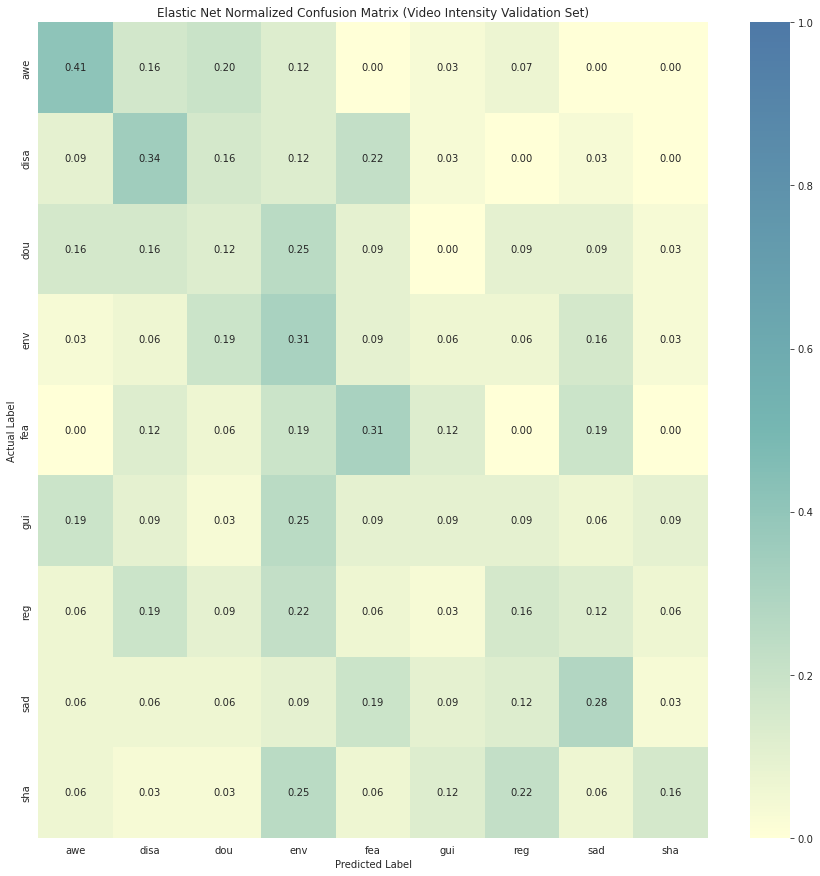

In [110]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

# get scores
scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('printing Area Under the Curve (AUC) measures')
print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True
                       )
      
print('printing Unweighted Average Recall (UAC) measures')
print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_confusion_matrix(df_cm, title='Elastic Net Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_elastic_net_intensity_video.svg')


# kNN Classifier

TODO: Might be smart to seed such that every emotion has it's own cluster starting point

In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group

# grid search number of clusters based on number of targets and number of samples 
floor = len(y.unique())
cap = (len(y) * 3/4)/2
n_neigh_values   = np.linspace(floor, cap, 50, dtype=np.int64).tolist()

# Define other to evaluate
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 2 folds for each of 450 candidates, totalling 900 fits
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     n_jobs=-1, n_neighbors=21)
